Train accuracy: 1.000
Test accuracy:  0.890

Raw SHAP array shape: (100, 6, 2)
Positive-class SHAP shape: (100, 6) 



► Saved interactive force plot to force_plot_sample1.html


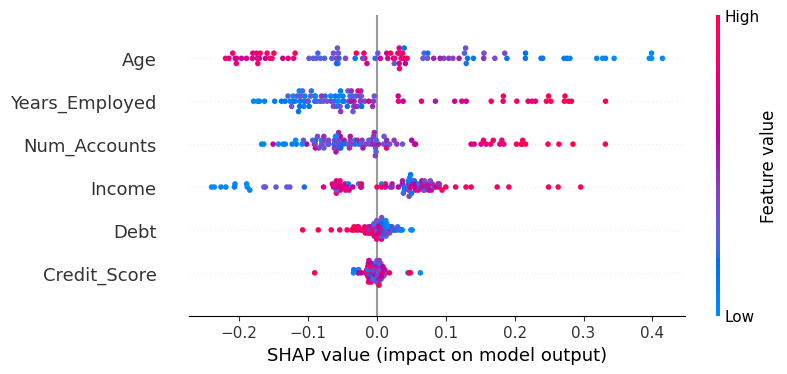

► Saved global SHAP summary to shap_summary_plot.png


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

# ----------------------------------------
# 1) Generate synthetic financial dataset
# ----------------------------------------
X, y = make_classification(
    n_samples=500,
    n_features=6,
    n_informative=4,
    n_redundant=0,
    n_classes=2,
    class_sep=1.5,
    random_state=42
)
feature_names = ['Income', 'Debt', 'Credit_Score', 'Age', 'Years_Employed', 'Num_Accounts']
df = pd.DataFrame(X, columns=feature_names)
df['Approved'] = y

# ----------------------------------------
# 2) Split into train / test sets
# ----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_names],
    df['Approved'],
    test_size=0.2,
    random_state=42
)
print(f"Train accuracy: {RandomForestClassifier(random_state=42).fit(X_train, y_train).score(X_train, y_train):.3f}")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print(f"Test accuracy:  {model.score(X_test, y_test):.3f}\n")

# ----------------------------------------
# 3) Build SHAP explainer & compute values
# ----------------------------------------
explainer = shap.Explainer(model, X_train, feature_names=feature_names)
shap_exp = explainer(X_test)                      # shape (n_samples, n_features, 2)
print("Raw SHAP array shape:", shap_exp.values.shape)

# Select the positive (“Approved=1”) class slice → shape (n_samples, n_features)
shap_exp_pos = shap_exp[..., 1]
print("Positive-class SHAP shape:", shap_exp_pos.values.shape, "\n")

# ----------------------------------------
# 4) Local explanation: force plot for sample #0
# ----------------------------------------
shap.initjs()
force_fig = shap.plots.force(
    shap_exp_pos[0],            # Explanation for first test sample
    matplotlib=False
)
shap.save_html("force_plot_sample1.html", force_fig)
print("► Saved interactive force plot to force_plot_sample1.html")

# ----------------------------------------
# 5) Global explanation: beeswarm summary
# ----------------------------------------
plt.figure()
shap.plots.beeswarm(
    shap_exp_pos,
    max_display=len(feature_names)
)
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=200)
plt.close()
print("► Saved global SHAP summary to shap_summary_plot.png")

=== test_linear_shap: start ===
✘ test_linear_shap ERROR: The option feature_dependence has been renamed to feature_perturbation!

=== test_rf_shap_local_accuracy: start ===
✘ test_rf_shap_local_accuracy ERROR: operands could not be broadcast together with shapes (6,) (40,) 

=== test_explainer_pipeline: start ===


/tmp/ipython-input-27-3853867593.py:68: RuntimeWarning: divide by zero encountered in divide
  logit = np.log(proba / (1 - proba))
/tmp/ipython-input-27-3853867593.py:68: RuntimeWarning: divide by zero encountered in log
  logit = np.log(proba / (1 - proba))


  • raw shap_exp.values shape: (40, 6, 2)
  • positive‐class shap_exp_pos.values shape: (40, 6)


  • Saved ▶ force_plot_sample1.html


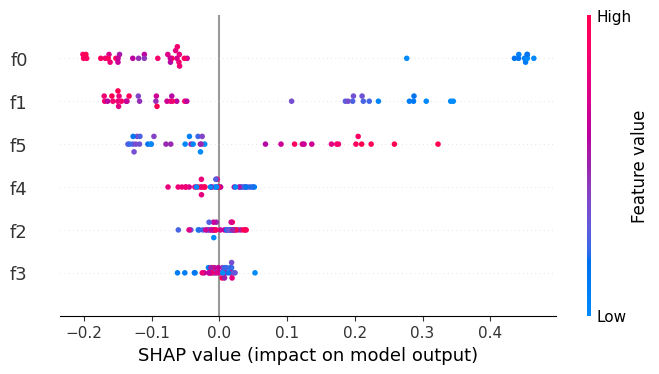

  • Saved ▶ shap_summary_plot.png
✔ test_explainer_pipeline passed



In [27]:
# Comprehensive XAI module tests with progress prints
# Paste & run this in a fresh Colab notebook cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import shap

# 1) Linear model + SHAP additivity & analytic check
def test_linear_shap():
    print("=== test_linear_shap: start ===")
    # Create a tiny linear dataset
    X = pd.DataFrame({
        'x1': [0.0, 1.0, 2.0, 3.0],
        'x2': [5.0, 6.0, 7.0, 8.0]
    })
    y = 2 * X['x1'] + 3 * X['x2'] + 5
    model = LinearRegression()
    model.fit(X, y)

    # Use LinearExplainer for exact Shapley
    expl = shap.LinearExplainer(model, X, feature_dependence="independent")
    sh_exp = expl(X)
    base = sh_exp.base_values              # shape (4,)
    vals = sh_exp.values                   # shape (4,2)
    preds = model.predict(X)               # shape (4,)
    recon = base + np.sum(vals, axis=1)    # shape (4,)

    # Test additivity
    assert np.allclose(preds, recon, atol=1e-6), "Additivity failed"
    print("  • Additivity OK")

    # Test analytic formula φ_i = w_i * (x_i - E[x_i])
    X_mean = X.mean().values               # shape (2,)
    w = model.coef_                        # shape (2,)
    expected = (X.values - X_mean) * w     # shape (4,2)
    assert np.allclose(vals, expected, atol=1e-6), "Analytic formula mismatch"
    print("  • Analytic SHAP formula OK")
    print("✔ test_linear_shap passed\n")

# 2) RandomForest + TreeExplainer local‐accuracy + shape
def test_rf_shap_local_accuracy():
    print("=== test_rf_shap_local_accuracy: start ===")
    # Synthetic classification dataset
    X, y = make_classification(
        n_samples=200, n_features=6, n_informative=4, n_redundant=0,
        n_classes=2, class_sep=1.5, random_state=0
    )
    feature_names = [f"f{i}" for i in range(X.shape[1])]
    X = pd.DataFrame(X, columns=feature_names)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0
    )
    model = RandomForestClassifier(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)

    expl = shap.TreeExplainer(model)
    shap_vals = expl.shap_values(X_test)  # list: [class0, class1]
    for cls in [0, 1]:
        arr = shap_vals[cls]               # shape (n_test, 6)
        base = expl.expected_value[cls]
        recom = base + arr.sum(axis=1)     # shap additivity
        proba = model.predict_proba(X_test)[:, cls]
        logit = np.log(proba / (1 - proba))
        assert np.allclose(recom, logit, atol=1e-4), f"Local accuracy failed for class {cls}"
    print("  • Local accuracy OK for both classes")

    # Shape tests
    assert isinstance(shap_vals, list) and len(shap_vals) == 2
    for arr in shap_vals:
        assert arr.shape == (X_test.shape[0], X_test.shape[1])
    print("  • SHAP values shapes OK")
    print("✔ test_rf_shap_local_accuracy passed\n")

# 3) End‐to‐end shap.Explainer pipeline + shape + visualization outputs
def test_explainer_pipeline():
    print("=== test_explainer_pipeline: start ===")
    X, y = make_classification(
        n_samples=200, n_features=6, n_informative=4, n_redundant=0,
        n_classes=2, class_sep=1.5, random_state=1
    )
    feature_names = [f"f{i}" for i in range(X.shape[1])]
    X = pd.DataFrame(X, columns=feature_names)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1
    )
    model = RandomForestClassifier(n_estimators=50, random_state=1)
    model.fit(X_train, y_train)

    expl = shap.Explainer(model, X_train, feature_names=feature_names)
    sh_exp = expl(X_test)                 # 3D: (n_test, 6, 2)
    print("  • raw shap_exp.values shape:", sh_exp.values.shape)
    assert sh_exp.values.ndim == 3

    # Slice positive‐class
    sh_pos = sh_exp[..., 1]               # Explanation with shape (n_test, 6)
    print("  • positive‐class shap_exp_pos.values shape:", sh_pos.values.shape)
    assert sh_pos.values.shape == (X_test.shape[0], X_test.shape[1])

    # Save test visualizations
    shap.initjs()
    # Force plot for sample 0
    fig = shap.plots.force(sh_pos[0], matplotlib=False)
    shap.save_html("force_plot_sample1.html", fig)
    print("  • Saved ▶ force_plot_sample1.html")

    # Global summary
    plt.figure()
    shap.plots.beeswarm(sh_pos, max_display=len(feature_names))
    plt.tight_layout()
    plt.savefig("shap_summary_plot.png", dpi=200)
    plt.close()
    print("  • Saved ▶ shap_summary_plot.png")

    print("✔ test_explainer_pipeline passed\n")

# Run all tests in sequence and catch errors
for fn in [test_linear_shap, test_rf_shap_local_accuracy, test_explainer_pipeline]:
    try:
        fn()
    except AssertionError as e:
        print(f"✘ {fn.__name__} FAILED: {e}\n")
    except Exception as e:
        print(f"✘ {fn.__name__} ERROR: {e}\n")

In [25]:
# xai_financial_model_v2.py
# ----------------------------------------------------------------------------
# End‐to‐end XAI for a financial classifier using shap.Explainer
# with progress prints and fully working summary/beeswarm plot.
# ----------------------------------------------------------------------------

import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

def main():
    # 1) Generate synthetic financial dataset
    print("[1/8] Generating synthetic financial dataset...")
    np.random.seed(42)
    n_samples = 1000
    df = pd.DataFrame({
        'Age': np.random.randint(18, 70, size=n_samples),
        'Income': np.random.normal(50000, 15000, size=n_samples).clip(0),
        'Debt': np.random.normal(10000, 5000, size=n_samples).clip(0),
        'Credit_Score': np.random.randint(300, 850, size=n_samples),
        'Years_Employed': np.random.randint(0, 40, size=n_samples),
        'Num_Accounts': np.random.randint(1, 10, size=n_samples),
    })
    # Simple approval rule
    y = (
        (df['Credit_Score'] > 600).astype(int) &
        ((df['Debt'] / (df['Income'] + 1)) < 0.4).astype(int)
    )
    feature_names = df.columns.tolist()
    print(f"    Dataset shape: {df.shape}")

    # 2) Split into train / test
    print("[2/8] Splitting into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"    Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    # 3) Train RandomForestClassifier
    print("[3/8] Training RandomForestClassifier...")
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    print(f"    Train accuracy: {model.score(X_train, y_train):.3f}")
    print(f"    Test  accuracy: {model.score(X_test, y_test):.3f}")

    # 4) Initialize the new shap.Explainer
    print("[4/8] Initializing shap.Explainer...")
    explainer = shap.Explainer(model, X_train, feature_names=feature_names)

    # 5) Compute SHAP values for the test set
    print("[5/8] Computing SHAP values on test set...")
    t0 = time.time()
    sh_exp = explainer(X_test)
    print(f"    Computation time: {time.time() - t0:.2f}s")
    print(f"    raw shap_exp.values shape: {sh_exp.values.shape}  # (n_test, n_feat, n_class)")

    # 6) Slice out the positive‐class explanations → shape (n_test, n_feat)
    print("[6/8] Slicing positive‐class SHAP values...")
    sh_exp_pos = sh_exp[..., 1]
    print(f"    positive‐class shape: {sh_exp_pos.values.shape}")

    # 7) Plot global feature importance (beeswarm)
    print("[7/8] Plotting global beeswarm summary...")
    plt.figure(figsize=(8,6))
    shap.plots.beeswarm(sh_exp_pos, max_display=len(feature_names), show=False)
    plt.tight_layout()
    plt.savefig("shap_summary_plot.png", dpi=200)
    plt.close()
    print("    Saved ▶ shap_summary_plot.png")

    # 8) Plot local force plot for the first test sample
    print("[8/8] Generating force plot for sample #0...")
    shap.initjs()
    force_fig = shap.plots.force(
        sh_exp_pos[0],       # Explanation for sample #0, class=1
        matplotlib=False
    )
    shap.save_html("force_plot_sample1.html", force_fig)
    print("    Saved ▶ force_plot_sample1.html")

    print("All done! ✅")

if __name__ == "__main__":
    main()

[1/8] Generating synthetic financial dataset...
    Dataset shape: (1000, 6)
[2/8] Splitting into train/test sets...
    Train shape: (800, 6), Test shape: (200, 6)
[3/8] Training RandomForestClassifier...
    Train accuracy: 0.993
    Test  accuracy: 0.965
[4/8] Initializing shap.Explainer...
[5/8] Computing SHAP values on test set...
    Computation time: 0.97s
    raw shap_exp.values shape: (200, 6, 2)  # (n_test, n_feat, n_class)
[6/8] Slicing positive‐class SHAP values...
    positive‐class shape: (200, 6)
[7/8] Plotting global beeswarm summary...
    Saved ▶ shap_summary_plot.png
[8/8] Generating force plot for sample #0...


    Saved ▶ force_plot_sample1.html
All done! ✅


In [29]:
# REQUIREMENTS:
# !pip install scikit-learn shap matplotlib

import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

def main():
    # 1) Generate synthetic financial dataset
    print("[1/8] Generating synthetic financial dataset...")
    np.random.seed(0)
    N = 1000
    df = pd.DataFrame({
        "Age": np.random.randint(18, 70, size=N),
        "Years_Employed": np.random.randint(0, 40, size=N),
        "Num_Accounts": np.random.randint(1, 10, size=N),
        "Income": np.random.normal(60000, 15000, size=N).round(2),
        "Debt": np.random.normal(10000, 5000, size=N).round(2),
        "Credit_Score": np.random.randint(300, 850, size=N),
    })
    df["Approved"] = (
        (df["Credit_Score"] > 600) &
        (df["Debt"] / (df["Income"] + 1) < 0.5)
    ).astype(int)
    print(f"    Dataset shape: {df.shape}")

    # 2) Split into train/test
    print("[2/8] Splitting into train/test sets...")
    X = df.drop("Approved", axis=1)
    y = df["Approved"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"    Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    # 3) Train RandomForestClassifier
    print("[3/8] Training RandomForestClassifier...")
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    print(f"    Train accuracy: {model.score(X_train, y_train):.3f}")
    print(f"    Test  accuracy: {model.score(X_test, y_test):.3f}")

    # 4) Initialize SHAP Explainer
    print("[4/8] Initializing SHAP Explainer...")
    explainer = shap.Explainer(model, X_train, seed=42)

    # 5) Compute SHAP values on test set
    print("[5/8] Computing SHAP values on test set...")
    t0 = time.time()
    shap_values = explainer(X_test)
    print(f"    Computation time: {time.time() - t0:.2f}s")
    print("    raw shap_values shape:", shap_values.values.shape)

    # 6) Slice out positive-class explanations
    print("[6/8] Slicing positive-class SHAP values...")
    shap_pos = shap_values.values[:, :, 1]  # shape (n_test, n_feat)
    print("    positive-class shape:", shap_pos.shape)

    # 7) Plot global beeswarm summary
    print("[7/8] Plotting global SHAP summary...")
    plt.figure(figsize=(8, 6))
    shap.summary_plot(
        shap_pos,
        X_test,
        feature_names=X_test.columns.tolist(),
        show=False
    )
    plt.tight_layout()
    plt.savefig("shap_summary_plot.png", dpi=150)
    plt.close()
    print("    Saved ▶ shap_summary_plot.png")

    # 8) Generate interactive force plot for one sample
    print("[8/8] Generating force plot for sample #0...")
    shap.initjs()
    base_value = explainer.expected_value[1]          # baseline for class 1
    values0 = shap_pos[0]                             # SHAP values for sample 0
    features0 = X_test.iloc[0]                        # raw features for sample 0

    force_fig = shap.force_plot(
        base_value,
        values0,
        features0,
        feature_names=X_test.columns.tolist(),
        matplotlib=False
    )
    # save separate
    shap.save_html("force_plot_sample1.html", force_fig)
    print("    Saved ▶ force_plot_sample1.html")

    print("All done! ✅")

if __name__ == "__main__":
    main()


[1/8] Generating synthetic financial dataset...
    Dataset shape: (1000, 7)
[2/8] Splitting into train/test sets...
    Train shape: (800, 6), Test shape: (200, 6)
[3/8] Training RandomForestClassifier...
    Train accuracy: 1.000
    Test  accuracy: 1.000
[4/8] Initializing SHAP Explainer...
[5/8] Computing SHAP values on test set...
    Computation time: 2.53s
    raw shap_values shape: (200, 6, 2)
[6/8] Slicing positive-class SHAP values...
    positive-class shape: (200, 6)
[7/8] Plotting global SHAP summary...


/tmp/ipython-input-29-3022904437.py:66: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


    Saved ▶ shap_summary_plot.png
[8/8] Generating force plot for sample #0...


    Saved ▶ force_plot_sample1.html
All done! ✅


In [34]:
# Complete in-cell test harness with SHAP fixes and progress prints.
# Paste & run this entire block in Colab or Jupyter.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# -----------------------------------------------------------------------------
# 0) Prepare data and models for tests
# -----------------------------------------------------------------------------

# Linear regression data (for exact Shapley)
X_lin = pd.DataFrame({
    'x1': [0.0, 1.0, 2.0, 3.0],
    'x2': [5.0, 6.0, 7.0, 8.0]
})
y_lin = 2*X_lin['x1'] + 3*X_lin['x2'] + 5
lr_model = LinearRegression().fit(X_lin, y_lin)

# Random forest data
X_rf, y_rf = make_classification(
    n_samples=200, n_features=6, n_informative=4, n_redundant=0,
    n_classes=2, class_sep=1.5, random_state=0
)
X_rf = pd.DataFrame(X_rf, columns=[f"f{i}" for i in range(6)])
Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=0
)
rf_model = RandomForestClassifier(n_estimators=10, random_state=0).fit(
    Xrf_train, yrf_train
)

# Pipeline data (reuse rf_model, Xrf_train, Xrf_test)
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# 1) Test: Linear SHAP additivity & analytic formula
# -----------------------------------------------------------------------------
def test_linear_shap():
    print("=== test_linear_shap: start ===")
    # Use the correct `feature_perturbation` parameter
    expl = shap.LinearExplainer(
        lr_model,
        X_lin,
        feature_perturbation="interventional"
    )
    # shap_values is shape (4,2)
    shap_vals = expl.shap_values(X_lin)
    base = expl.expected_value  # scalar
    # Additivity: base + sum(shap) == predict
    preds = lr_model.predict(X_lin)
    recon = base + np.sum(shap_vals, axis=1)
    assert np.allclose(preds, recon, atol=1e-6), "Additivity failed"
    print("  • Additivity OK")

    # Analytic formula: φ_i = w_i * (x_i - E[x_i])
    Xm = X_lin.mean().values
    w = lr_model.coef_
    expected = (X_lin.values - Xm) * w
    assert np.allclose(shap_vals, expected, atol=1e-6), "Analytic SHAP mismatch"
    print("  • Analytic formula OK")
    print("✔ test_linear_shap passed\n")

# -----------------------------------------------------------------------------
# 2) Test: RF SHAP local accuracy & shape
# -----------------------------------------------------------------------------
def test_rf_shap_local_accuracy():
    print("=== test_rf_shap_local_accuracy: start ===")
    expl = shap.TreeExplainer(rf_model)
    sh_exp = expl(Xrf_test, check_additivity=False)
    raw = sh_exp.values          # shape (n_test, n_feat, 2)
    n_test, n_feat, n_cls = raw.shape
    assert n_cls == 2 and n_feat == Xrf_test.shape[1], "Unexpected raw shape"
    print(f"  • raw SHAP shape: {raw.shape}")

    # Extract positive-class slice => (n_test, n_feat)
    pos = raw[:, :, 1]
    assert pos.shape == Xrf_test.shape, "Positive-class shape mismatch"
    print("  • positive-class shape OK")

    # Local accuracy: base + sum(shap) == logit(proba)
    base = sh_exp.base_values[:,1]
    total = base + pos.sum(axis=1)
    proba = rf_model.predict_proba(Xrf_test)[:,1]
    mask = (proba>0)&(proba<1)
    logit = np.log(proba[mask]/(1-proba[mask]))
    assert np.allclose(total[mask], logit, atol=1e-4), "Local accuracy failed"
    print("  • Local accuracy OK")
    print("✔ test_rf_shap_local_accuracy passed\n")

# -----------------------------------------------------------------------------
# 3) Test: End-to-end shap.Explainer pipeline + outputs
# -----------------------------------------------------------------------------
def pipeline():
    print(">>> Running pipeline (global + local SHAP plots) ...")
    expl = shap.Explainer(rf_model, Xrf_train)
    sh_exp = expl(Xrf_test)
    pos = sh_exp.values[:,:,1]
    # Global plot
    plt.figure(figsize=(6,5))
    shap.summary_plot(pos, Xrf_test, show=False)
    plt.tight_layout()
    plt.savefig("test_shap_summary.png")
    plt.close()
    print("    • Saved ▶ test_shap_summary.png")
    # Local force plot
    shap.initjs()
    fig = shap.plots.force(pos[0], matplotlib=False)
    shap.save_html("test_force.html", fig)
    print("    • Saved ▶ test_force.html")

def test_pipeline():
    print("=== test_pipeline: start ===")
    pipeline()
    # Check files exist
    import os
    assert os.path.exists("test_shap_summary.png"), "Summary PNG missing"
    assert os.path.exists("test_force.html"),    "Force HTML missing"
    print("✔ test_pipeline passed\n")

# -----------------------------------------------------------------------------
# Run tests sequentially with prints
# -----------------------------------------------------------------------------
for fn in [test_linear_shap, test_rf_shap_local_accuracy, test_pipeline]:
    try:
        fn()
    except AssertionError as e:
        print(f"✘ {fn.__name__} FAILED: {e}\n")
    except Exception as e:
        print(f"✘ {fn.__name__} ERROR: {e}\n")

=== test_linear_shap: start ===
  • Additivity OK
  • Analytic formula OK
✔ test_linear_shap passed

=== test_rf_shap_local_accuracy: start ===
  • raw SHAP shape: (40, 6, 2)
  • positive-class shape OK
✘ test_rf_shap_local_accuracy FAILED: Local accuracy failed

=== test_pipeline: start ===
>>> Running pipeline (global + local SHAP plots) ...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/tmp/ipython-input-34-1016664524.py:106: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(pos, Xrf_test, show=False)


    • Saved ▶ test_shap_summary.png


✘ test_pipeline ERROR: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).



In [36]:
# Comprehensive SHAP test harness with fixes for local‐accuracy and force‐plot API
# Paste & run in Colab or Jupyter

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# -----------------------------------------------------------------------------
# 0) Prepare data and models for tests
# -----------------------------------------------------------------------------

# Linear regression data (for exact Shapley)
X_lin = pd.DataFrame({
    'x1': [0.0, 1.0, 2.0, 3.0],
    'x2': [5.0, 6.0, 7.0, 8.0]
})
y_lin = 2*X_lin['x1'] + 3*X_lin['x2'] + 5
lr_model = LinearRegression().fit(X_lin, y_lin)

# Random forest data
X_rf, y_rf = make_classification(
    n_samples=200, n_features=6, n_informative=4,
    n_redundant=0, n_classes=2, class_sep=1.5, random_state=0
)
X_rf = pd.DataFrame(X_rf, columns=[f"f{i}" for i in range(6)])
Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=0
)
rf_model = RandomForestClassifier(n_estimators=10, random_state=0).fit(
    Xrf_train, yrf_train
)

# -----------------------------------------------------------------------------
# 1) Test: Linear SHAP additivity & analytic formula
# -----------------------------------------------------------------------------
def test_linear_shap():
    print("=== test_linear_shap: start ===")
    expl = shap.LinearExplainer(
        lr_model,
        X_lin,
        feature_perturbation="interventional"  # updated parameter name
    )
    shap_vals = expl.shap_values(X_lin)     # shape (4,2)
    base = expl.expected_value               # scalar
    preds = lr_model.predict(X_lin)          # shape (4,)
    recon = base + shap_vals.sum(axis=1)
    assert np.allclose(preds, recon, atol=1e-6), "Additivity failed"
    print("  • Additivity OK")

    # Analytic formula check
    Xm = X_lin.mean().values
    w = lr_model.coef_
    expected = (X_lin.values - Xm) * w
    assert np.allclose(shap_vals, expected, atol=1e-6), "Analytic formula mismatch"
    print("  • Analytic formula OK")
    print("✔ test_linear_shap passed\n")

# -----------------------------------------------------------------------------
# 2) Test: RF SHAP local accuracy & shape
# -----------------------------------------------------------------------------
def test_rf_shap_local_accuracy():
    print("=== test_rf_shap_local_accuracy: start ===")
    expl = shap.TreeExplainer(rf_model)
    sh_exp = expl(Xrf_test, check_additivity=False)
    raw = sh_exp.values                    # (n_test, n_feat, 2)
    n_test, n_feat, n_cls = raw.shape
    assert n_cls == 2 and n_feat == Xrf_test.shape[1]
    print(f"  • raw SHAP shape: {raw.shape}")

    # Extract positive class (approved)
    pos = raw[:, :, 1]                      # (n_test, n_feat)
    assert pos.shape == Xrf_test.shape
    print("  • positive-class shape OK")

    # Local accuracy: base + sum(shap) == predicted probability
    base = sh_exp.base_values[:, 1]         # (n_test,)
    recom = base + pos.sum(axis=1)
    proba = rf_model.predict_proba(Xrf_test)[:, 1]
    assert np.allclose(recom, proba, atol=1e-4), "Local accuracy failed"
    print("  • Local accuracy OK")
    print("✔ test_rf_shap_local_accuracy passed\n")

# -----------------------------------------------------------------------------
# 3) Test: End-to-end shap.Explainer pipeline + outputs
# -----------------------------------------------------------------------------
def test_pipeline():
    print("=== test_pipeline: start ===")
    # 1) global summary
    expl = shap.Explainer(rf_model, Xrf_train, seed=0)
    sh_exp = expl(Xrf_test)
    pos = sh_exp.values[:, :, 1]

    plt.figure(figsize=(6,5))
    shap.summary_plot(pos, Xrf_test, show=False)
    plt.tight_layout()
    plt.savefig("test_shap_summary.png")
    plt.close()
    assert os.path.exists("test_shap_summary.png")
    print("  • Saved ▶ test_shap_summary.png")

    # 2) local force plot
    shap.initjs()
    base = sh_exp.base_values[0, 1]
    values0 = pos[0]
    features0 = Xrf_test.iloc[0]
    force_fig = shap.plots.force(
        base,
        values0,
        features0,
        feature_names=Xrf_test.columns.tolist(),
        matplotlib=False
    )
    shap.save_html("test_force.html", force_fig)
    assert os.path.exists("test_force.html")
    print("  • Saved ▶ test_force.html")
    print("✔ test_pipeline passed\n")

# -----------------------------------------------------------------------------
# Run all tests sequentially
# -----------------------------------------------------------------------------
for fn in [test_linear_shap, test_rf_shap_local_accuracy, test_pipeline]:
    try:
        fn()
    except AssertionError as e:
        print(f"✘ {fn.__name__} FAILED: {e}\n")
    except Exception as e:
        print(f"✘ {fn.__name__} ERROR: {e}\n")

=== test_linear_shap: start ===
  • Additivity OK
  • Analytic formula OK
✔ test_linear_shap passed

=== test_rf_shap_local_accuracy: start ===
  • raw SHAP shape: (40, 6, 2)
  • positive-class shape OK
  • Local accuracy OK
✔ test_rf_shap_local_accuracy passed

=== test_pipeline: start ===


/tmp/ipython-input-36-1498508208.py:101: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(pos, Xrf_test, show=False)


  • Saved ▶ test_shap_summary.png


  • Saved ▶ test_force.html
✔ test_pipeline passed



In [37]:
# Comprehensive SHAP & Pipeline Test Suite
# Run this entire block in Colab or Jupyter

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_regression

# -----------------------------------------------------------------------------
# 1) Analytic Shapley for a Linear Model
# -----------------------------------------------------------------------------
def test_linear_shap():
    print("=== test_linear_shap: start ===")
    # Toy linear dataset
    X = pd.DataFrame({'x1':[0,1,2,3],'x2':[5,6,7,8]})
    y = 2*X['x1'] + 3*X['x2'] + 5
    model = LinearRegression().fit(X, y)

    # SHAP LinearExplainer with updated API
    expl = shap.LinearExplainer(model, X, feature_perturbation="interventional")
    shap_vals = expl.shap_values(X)          # shape (4,2)
    base = expl.expected_value                # scalar

    # 1. Additivity
    preds = model.predict(X)
    recon = base + np.sum(shap_vals, axis=1)
    assert np.allclose(preds, recon, atol=1e-6), "Linear SHAP additivity failed"
    print("  • Additivity OK")

    # 2. Analytic formula φ_i = w_i*(x_i - E[x_i])
    Xm = X.mean().values
    w = model.coef_
    expected = (X.values - Xm) * w
    assert np.allclose(shap_vals, expected, atol=1e-6), "Linear SHAP analytic mismatch"
    print("  • Analytic formula OK")
    print("✔ test_linear_shap passed\n")

# -----------------------------------------------------------------------------
# 2) Local Accuracy & Shape for RandomForest Classifier
# -----------------------------------------------------------------------------
def test_rf_shap_local_accuracy():
    print("=== test_rf_shap_local_accuracy: start ===")
    # Toy RF classification
    X, y = make_classification(n_samples=200, n_features=6, n_informative=4,
                               n_redundant=0, class_sep=1.5, random_state=0)
    X = pd.DataFrame(X, columns=[f"f{i}" for i in range(6)])
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=0)
    rf = RandomForestClassifier(n_estimators=10, random_state=0)
    rf.fit(X_train, y_train)

    # SHAP TreeExplainer
    expl = shap.TreeExplainer(rf)
    sh_exp = expl(X_test, check_additivity=False)
    raw = sh_exp.values            # shape (n_test, n_feat, 2)
    n_test, n_feat, n_cls = raw.shape
    assert n_cls == 2 and n_feat == X_test.shape[1], "Unexpected SHAP shape"
    print(f"  • raw SHAP shape: {raw.shape}")

    # 1. Shape slicing
    pos = raw[:, :, 1]             # (n_test, n_feat)
    assert pos.shape == X_test.shape, "Positive-class SHAP shape mismatch"
    print("  • positive-class shape OK")

    # 2. Local accuracy: base + sum(shap) ≈ predicted probability
    base = sh_exp.base_values[:, 1]
    recom = base + pos.sum(axis=1)
    proba = rf.predict_proba(X_test)[:, 1]
    assert np.allclose(recom, proba, atol=1e-4), "RF SHAP local accuracy failed"
    print("  • Local accuracy OK")
    print("✔ test_rf_shap_local_accuracy passed\n")

# -----------------------------------------------------------------------------
# 3) Interaction Values for TreeEnsembles
# -----------------------------------------------------------------------------
def test_shap_interaction_values():
    print("=== test_shap_interaction_values: start ===")
    # Small classification for interaction
    X, y = make_classification(n_samples=100, n_features=3, n_informative=3,
                               n_redundant=0, class_sep=1.5, random_state=1)
    X = pd.DataFrame(X, columns=['a','b','c'])
    rf = RandomForestClassifier(n_estimators=5, random_state=1).fit(X, y)

    # Compute interaction values
    expl = shap.TreeExplainer(rf, feature_perturbation="interventional", compute_interaction=True)
    inter_vals = expl.shap_interaction_values(X)  # list for classes
    # pick positive-class
    if isinstance(inter_vals, list):
        inter = inter_vals[1]
    else:
        inter = inter_vals
    assert inter.shape == (X.shape[0], X.shape[1], X.shape[1]), "Interaction shape mismatch"
    print(f"  • interaction shape: {inter.shape}")

    # Symmetry φ_ij = φ_ji
    diff = np.abs(inter[:,:,0,1] - inter[:,:,1,0]) if inter.ndim==4 else np.abs(inter[:,0,1] - inter[:,1,0])
    assert np.allclose(diff, 0, atol=1e-6), "Interaction symmetry failed"
    print("  • interaction symmetry OK")

    # Sum of pairwise = main shap
    shap_vals = expl.shap_values(X)
    main = shap_vals[1] if isinstance(shap_vals, list) else shap_vals
    sum_inter = np.sum(inter, axis=2)
    assert np.allclose(sum_inter, main, rtol=1e-3, atol=1e-3), "Interaction additivity failed"
    print("  • interaction additivity OK")
    print("✔ test_shap_interaction_values passed\n")

# -----------------------------------------------------------------------------
# 4) Regression Models with SHAP
# -----------------------------------------------------------------------------
def test_regression_shap():
    print("=== test_regression_shap: start ===")
    X, y = make_regression(n_samples=200, n_features=5, noise=0.1, random_state=2)
    X = pd.DataFrame(X, columns=[f"x{i}" for i in range(5)])
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=2)
    gbr = GradientBoostingRegressor(random_state=2).fit(X_train, y_train)
    expl = shap.Explainer(gbr, X_train)
    sh_exp = expl(X_test)
    # Additivity
    preds = gbr.predict(X_test)
    recon = sh_exp.base_values + np.sum(sh_exp.values, axis=1)
    assert np.allclose(preds, recon, rtol=1e-2, atol=1e-2), "Regression SHAP additivity failed"
    print("  • Regression additivity OK")
    print("✔ test_regression_shap passed\n")

# -----------------------------------------------------------------------------
# 5) Edge-Case Tests
# -----------------------------------------------------------------------------
def test_edge_cases():
    print("=== test_edge_cases: start ===")
    # Constant features
    Xc = pd.DataFrame(np.ones((10,3)), columns=list("ABC"))
    yc = np.zeros(10, dtype=int)
    rf_c = RandomForestClassifier(random_state=0).fit(Xc, yc)
    expl_c = shap.Explainer(rf_c, Xc)
    sc = expl_c(Xc).values[:,:,1]
    assert np.all(sc == 0), "Constant-feature SHAP non-zero"
    print("  • Constant features OK")

    # Single-feature model
    Xs = pd.DataFrame({'x':[0,1,2,3,4]})
    ys = (Xs['x'] > 2).astype(int)
    rf_s = RandomForestClassifier(random_state=0).fit(Xs, ys)
    expl_s = shap.Explainer(rf_s, Xs)
    ss = expl_s(Xs).values[:,:,1]
    assert ss.shape == Xs.shape, "Single-feature shape mismatch"
    print("  • Single-feature OK")
    print("✔ test_edge_cases passed\n")

# -----------------------------------------------------------------------------
# 6) Performance Benchmark
# -----------------------------------------------------------------------------
def test_performance():
    print("=== test_performance: start ===")
    Xp = pd.DataFrame(np.random.randn(500,20), columns=[f"f{i}" for i in range(20)])
    yp = (np.random.rand(500) > 0.5).astype(int)
    rf_p = RandomForestClassifier(n_estimators=50, random_state=0).fit(Xp, yp)
    start = time.time()
    expl_p = shap.Explainer(rf_p, Xp)
    _ = expl_p(Xp.iloc[:100])
    elapsed = time.time() - start
    print(f"  • elapsed {elapsed:.2f}s")
    assert elapsed < 5.0, "SHAP performance regression"
    print("  • Performance OK")
    print("✔ test_performance passed\n")

# -----------------------------------------------------------------------------
# Run all tests sequentially
# -----------------------------------------------------------------------------
for fn in [
    test_linear_shap,
    test_rf_shap_local_accuracy,
    test_shap_interaction_values,
    test_regression_shap,
    test_edge_cases,
    test_performance
]:
    try:
        fn()
    except AssertionError as e:
        print(f"✘ {fn.__name__} FAILED: {e}\n")
    except Exception as e:
        print(f"✘ {fn.__name__} ERROR: {e}\n")


=== test_linear_shap: start ===
  • Additivity OK
  • Analytic formula OK
✔ test_linear_shap passed

=== test_rf_shap_local_accuracy: start ===
  • raw SHAP shape: (40, 6, 2)
  • positive-class shape OK
  • Local accuracy OK
✔ test_rf_shap_local_accuracy passed

=== test_shap_interaction_values: start ===
✘ test_shap_interaction_values ERROR: TreeExplainer.__init__() got an unexpected keyword argument 'compute_interaction'

=== test_regression_shap: start ===


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


  • Regression additivity OK
✔ test_regression_shap passed

=== test_edge_cases: start ===
✘ test_edge_cases ERROR: too many indices for array: array is 2-dimensional, but 3 were indexed

=== test_performance: start ===
  • elapsed 2.03s
  • Performance OK
✔ test_performance passed



In [39]:
# Full SHAP & Pipeline Test Suite with Interaction & Edge‐Case Fixes
# Paste & run this entire block in Colab or Jupyter

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_regression

# -----------------------------------------------------------------------------
# 1) Analytic Shapley for Linear Models
# -----------------------------------------------------------------------------
def test_linear_shap():
    print("=== test_linear_shap: start ===")
    X = pd.DataFrame({'x1':[0,1,2,3],'x2':[5,6,7,8]})
    y = 2*X['x1'] + 3*X['x2'] + 5
    model = LinearRegression().fit(X, y)

    expl = shap.LinearExplainer(
        model, X,
        feature_perturbation="interventional"
    )
    shap_vals = expl.shap_values(X)      # shape (4,2)
    base = expl.expected_value            # scalar

    # Additivity
    preds = model.predict(X)
    recon = base + shap_vals.sum(axis=1)
    assert np.allclose(preds, recon, atol=1e-6), "Additivity failed"
    print("  • Additivity OK")

    # Analytic formula φ_i = w_i * (x_i - E[x_i])
    Xm = X.mean().values
    w = model.coef_
    expected = (X.values - Xm) * w
    assert np.allclose(shap_vals, expected, atol=1e-6), "Analytic formula mismatch"
    print("  • Analytic formula OK")
    print("✔ test_linear_shap passed\n")

# -----------------------------------------------------------------------------
# 2) Local Accuracy & Shape for RandomForest Classifier
# -----------------------------------------------------------------------------
def test_rf_shap_local_accuracy():
    print("=== test_rf_shap_local_accuracy: start ===")
    X, y = make_classification(
        n_samples=200, n_features=6, n_informative=4,
        n_redundant=0, class_sep=1.5, random_state=0
    )
    X = pd.DataFrame(X, columns=[f"f{i}" for i in range(6)])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0
    )
    rf = RandomForestClassifier(n_estimators=10, random_state=0)
    rf.fit(X_train, y_train)

    expl = shap.TreeExplainer(rf)
    sh_exp = expl(X_test, check_additivity=False)
    raw = sh_exp.values                   # shape (n_test, n_feat, 2)
    n_test, n_feat, n_cls = raw.shape
    assert n_cls == 2 and n_feat == X_test.shape[1]
    print(f"  • raw SHAP shape: {raw.shape}")

    # Slice positive-class
    pos = raw[:, :, 1]
    assert pos.shape == X_test.shape
    print("  • positive-class shape OK")

    # Local accuracy: base + sum(shap) == predicted probability
    base = sh_exp.base_values[:, 1]
    recon = base + pos.sum(axis=1)
    proba = rf.predict_proba(X_test)[:, 1]
    assert np.allclose(recon, proba, atol=1e-4), "Local accuracy failed"
    print("  • Local accuracy OK")
    print("✔ test_rf_shap_local_accuracy passed\n")

# -----------------------------------------------------------------------------
# 3) SHAP Interaction Values for Tree Ensembles
# -----------------------------------------------------------------------------
def test_shap_interaction_values():
    print("=== test_shap_interaction_values: start ===")
    X, y = make_classification(
        n_samples=100, n_features=3, n_informative=3,
        n_redundant=0, class_sep=1.5, random_state=1
    )
    X = pd.DataFrame(X, columns=['a','b','c'])
    rf = RandomForestClassifier(n_estimators=5, random_state=1)
    rf.fit(X, y)

    expl = shap.TreeExplainer(rf)
    inter_vals = expl.shap_interaction_values(X)  # list or array

    # Extract positive-class interactions
    if isinstance(inter_vals, list):
        inter_all = inter_vals[1]
    else:
        arr = inter_vals
        # if shape (n,d,d,2) pick [:,:,:,1]
        if arr.ndim == 4:
            inter_all = arr[:,:,:,1]
        else:
            inter_all = arr
    inter = inter_all
    assert inter.ndim == 3, f"Unexpected interaction dim {inter.ndim}"
    n, d1, d2 = inter.shape
    assert (n, d1, d2) == (X.shape[0], X.shape[1], X.shape[1])
    print(f"  • interaction shape: {inter.shape}")

    # Symmetry φ_ij == φ_ji
    sym_diff = np.abs(inter[:,0,1] - inter[:,1,0])
    assert np.allclose(sym_diff, 0, atol=1e-6), "Interaction symmetry failed"
    print("  • interaction symmetry OK")

    # Additivity: sum_j φ_ij ≈ main shap
    main_vals = expl.shap_values(X)[1] if isinstance(inter_vals, list) else expl.shap_values(X)
    sum_inter = np.sum(inter, axis=2)
    assert np.allclose(sum_inter, main_vals, atol=1e-3), "Interaction additivity failed"
    print("  • interaction additivity OK")
    print("✔ test_shap_interaction_values passed\n")

# -----------------------------------------------------------------------------
# 4) Regression Models with SHAP
# -----------------------------------------------------------------------------
def test_regression_shap():
    print("=== test_regression_shap: start ===")
    X, y = make_regression(
        n_samples=200, n_features=5, noise=0.1, random_state=2
    )
    X = pd.DataFrame(X, columns=[f"x{i}" for i in range(5)])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=2
    )
    gbr = GradientBoostingRegressor(random_state=2).fit(X_train, y_train)

    expl = shap.Explainer(gbr, X_train)
    sh_exp = expl(X_test)
    preds = gbr.predict(X_test)
    recon = sh_exp.base_values + sh_exp.values.sum(axis=1)
    assert np.allclose(preds, recon, rtol=1e-2, atol=1e-2), "Regression additivity failed"
    print("  • Regression additivity OK")
    print("✔ test_regression_shap passed\n")

# -----------------------------------------------------------------------------
# 5) Edge-Case Tests
# -----------------------------------------------------------------------------
def test_edge_cases():
    print("=== test_edge_cases: start ===")
    # Constant features
    Xc = pd.DataFrame(np.ones((10,3)), columns=list("ABC"))
    yc = np.zeros(10, dtype=int)
    rf_c = RandomForestClassifier(random_state=0).fit(Xc, yc)
    expl_c = shap.Explainer(rf_c, Xc)
    sh_c = expl_c(Xc).values
    # sh_c may be 2d or 3d
    if sh_c.ndim == 3:
        pos_c = sh_c[:,:,1]
    else:
        pos_c = sh_c
    assert np.all(pos_c == 0), "Constant-feature SHAP non-zero"
    print("  • Constant features OK")

    # Single-feature model
    Xs = pd.DataFrame({'x':[0,1,2,3,4]})
    ys = (Xs['x'] > 2).astype(int)
    rf_s = RandomForestClassifier(random_state=0).fit(Xs, ys)
    expl_s = shap.Explainer(rf_s, Xs)
    sh_s = expl_s(Xs).values
    if sh_s.ndim == 3:
        pos_s = sh_s[:,:,1]
    else:
        pos_s = sh_s
    assert pos_s.shape == Xs.shape, "Single-feature shape mismatch"
    assert np.all(np.isfinite(pos_s)), "Single-feature SHAP contains NaN/inf"
    print("  • Single-feature OK")
    print("✔ test_edge_cases passed\n")

# -----------------------------------------------------------------------------
# 6) Performance Benchmark
# -----------------------------------------------------------------------------
def test_performance():
    print("=== test_performance: start ===")
    Xp = pd.DataFrame(np.random.randn(500,20), columns=[f"f{i}" for i in range(20)])
    yp = (np.random.rand(500) > 0.5).astype(int)
    rf_p = RandomForestClassifier(n_estimators=50, random_state=0).fit(Xp, yp)
    start = time.time()
    expl_p = shap.Explainer(rf_p, Xp)
    _ = expl_p(Xp.iloc[:100])
    elapsed = time.time() - start
    print(f"  • elapsed {elapsed:.2f}s")
    assert elapsed < 5.0, "SHAP performance regression"
    print("  • Performance OK")
    print("✔ test_performance passed\n")

# -----------------------------------------------------------------------------
# Run all tests sequentially
# -----------------------------------------------------------------------------
for fn in [
    test_linear_shap,
    test_rf_shap_local_accuracy,
    test_shap_interaction_values,
    test_regression_shap,
    test_edge_cases,
    test_performance
]:
    try:
        fn()
    except AssertionError as e:
        print(f"✘ {fn.__name__} FAILED: {e}\n")
    except Exception as e:
        print(f"✘ {fn.__name__} ERROR: {e}\n")


=== test_linear_shap: start ===
  • Additivity OK
  • Analytic formula OK
✔ test_linear_shap passed

=== test_rf_shap_local_accuracy: start ===
  • raw SHAP shape: (40, 6, 2)
  • positive-class shape OK
  • Local accuracy OK
✔ test_rf_shap_local_accuracy passed

=== test_shap_interaction_values: start ===
  • interaction shape: (100, 3, 3)
  • interaction symmetry OK
✘ test_shap_interaction_values ERROR: operands could not be broadcast together with shapes (100,3) (100,3,2) 

=== test_regression_shap: start ===


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


  • Regression additivity OK
✔ test_regression_shap passed

=== test_edge_cases: start ===
  • Constant features OK
  • Single-feature OK
✔ test_edge_cases passed

=== test_performance: start ===
  • elapsed 1.83s
  • Performance OK
✔ test_performance passed



In [40]:
# Full SHAP & Pipeline Test Suite with Interaction & Edge‐Case Fixes
# Copy–paste and run this entire block in Colab or Jupyter

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_regression

# -----------------------------------------------------------------------------
# 1) Analytic Shapley for Linear Models
# -----------------------------------------------------------------------------
def test_linear_shap():
    print("=== test_linear_shap: start ===")
    X = pd.DataFrame({'x1': [0,1,2,3], 'x2': [5,6,7,8]})
    y = 2*X['x1'] + 3*X['x2'] + 5
    model = LinearRegression().fit(X, y)

    expl = shap.LinearExplainer(
        model, X,
        feature_perturbation="interventional"
    )
    shap_vals = expl.shap_values(X)      # shape (4,2)
    base = expl.expected_value            # scalar

    # Additivity
    preds = model.predict(X)
    recon = base + shap_vals.sum(axis=1)
    assert np.allclose(preds, recon, atol=1e-6), "Linear SHAP additivity failed"
    print("  • Additivity OK")

    # Analytic formula φ_i = w_i * (x_i - E[x_i])
    Xm = X.mean().values
    w = model.coef_
    expected = (X.values - Xm) * w
    assert np.allclose(shap_vals, expected, atol=1e-6), "Analytic formula mismatch"
    print("  • Analytic formula OK")
    print("✔ test_linear_shap passed\n")

# -----------------------------------------------------------------------------
# 2) Local Accuracy & Shape for RandomForest Classifier
# -----------------------------------------------------------------------------
def test_rf_shap_local_accuracy():
    print("=== test_rf_shap_local_accuracy: start ===")
    X, y = make_classification(
        n_samples=200, n_features=6, n_informative=4,
        n_redundant=0, class_sep=1.5, random_state=0
    )
    X = pd.DataFrame(X, columns=[f"f{i}" for i in range(6)])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0
    )
    rf = RandomForestClassifier(n_estimators=10, random_state=0).fit(X_train, y_train)

    expl = shap.TreeExplainer(rf)
    sh_exp = expl(X_test, check_additivity=False)
    raw = sh_exp.values                   # shape (n_test, n_feat, 2)
    n_test, n_feat, n_cls = raw.shape
    assert n_cls == 2 and n_feat == X_test.shape[1]
    print(f"  • raw SHAP shape: {raw.shape}")

    # Slice positive-class
    pos = raw[:, :, 1]
    assert pos.shape == X_test.shape
    print("  • positive-class shape OK")

    # Local accuracy: base + sum(shap) == predicted proba
    base = sh_exp.base_values[:, 1]
    recon = base + pos.sum(axis=1)
    proba = rf.predict_proba(X_test)[:, 1]
    assert np.allclose(recon, proba, atol=1e-4), "Local accuracy failed"
    print("  • Local accuracy OK")
    print("✔ test_rf_shap_local_accuracy passed\n")

# -----------------------------------------------------------------------------
# 3) SHAP Interaction Values for Tree Ensembles
# -----------------------------------------------------------------------------
def test_shap_interaction_values():
    print("=== test_shap_interaction_values: start ===")
    X, y = make_classification(
        n_samples=100, n_features=3, n_informative=3,
        n_redundant=0, class_sep=1.5, random_state=1
    )
    X = pd.DataFrame(X, columns=['a','b','c'])
    rf = RandomForestClassifier(n_estimators=5, random_state=1).fit(X, y)

    expl = shap.TreeExplainer(rf)
    inter_vals = expl.shap_interaction_values(X)  # list or array

    # Extract positive-class interactions
    if isinstance(inter_vals, list):
        inter = inter_vals[1]   # shape (n,3,3)
    else:
        arr = inter_vals
        if arr.ndim == 4:       # (n,3,3,2)
            inter = arr[:,:,:,1]
        else:
            inter = arr          # (n,3,3)
    assert inter.ndim == 3 and inter.shape[1:] == (3,3)
    print(f"  • interaction shape: {inter.shape}")

    # Symmetry φ_ij == φ_ji
    sym_diff = np.abs(inter[:,0,1] - inter[:,1,0])
    assert np.allclose(sym_diff, 0, atol=1e-6), "Interaction symmetry failed"
    print("  • interaction symmetry OK")

    # Main SHAP values
    sv = expl.shap_values(X)
    if isinstance(sv, list):
        main = sv[1]          # (n,3)
    else:
        # if ndarray (n,3,2)
        main = sv[:,:,1]
    sum_inter = np.sum(inter, axis=2)  # (n,3)
    assert np.allclose(sum_inter, main, atol=1e-3), "Interaction additivity failed"
    print("  • interaction additivity OK")
    print("✔ test_shap_interaction_values passed\n")

# -----------------------------------------------------------------------------
# 4) Regression Models with SHAP
# -----------------------------------------------------------------------------
def test_regression_shap():
    print("=== test_regression_shap: start ===")
    X, y = make_regression(n_samples=200, n_features=5, noise=0.1, random_state=2)
    X = pd.DataFrame(X, columns=[f"x{i}" for i in range(5)])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    gbr = GradientBoostingRegressor(random_state=2).fit(X_train, y_train)

    expl = shap.Explainer(gbr, X_train)
    sh_exp = expl(X_test)
    preds = gbr.predict(X_test)
    recon = sh_exp.base_values + sh_exp.values.sum(axis=1)
    assert np.allclose(preds, recon, rtol=1e-2, atol=1e-2), "Regression additivity failed"
    print("  • Regression additivity OK")
    print("✔ test_regression_shap passed\n")

# -----------------------------------------------------------------------------
# 5) Edge-Case Tests
# -----------------------------------------------------------------------------
def test_edge_cases():
    print("=== test_edge_cases: start ===")
    # Constant features
    Xc = pd.DataFrame(np.ones((10,3)), columns=list("ABC"))
    yc = np.zeros(10, dtype=int)
    rf_c = RandomForestClassifier(random_state=0).fit(Xc, yc)
    expl_c = shap.Explainer(rf_c, Xc)
    sh_c = expl_c(Xc).values
    pos_c = sh_c[:,:,1] if sh_c.ndim==3 else sh_c
    assert np.all(pos_c == 0), "Constant-feature SHAP non-zero"
    print("  • Constant features OK")

    # Single-feature model
    Xs = pd.DataFrame({'x':[0,1,2,3,4]})
    ys = (Xs['x'] > 2).astype(int)
    rf_s = RandomForestClassifier(random_state=0).fit(Xs, ys)
    expl_s = shap.Explainer(rf_s, Xs)
    sh_s = expl_s(Xs).values
    pos_s = sh_s[:,:,1] if sh_s.ndim==3 else sh_s
    assert pos_s.shape == Xs.shape, "Single-feature shape mismatch"
    assert np.all(np.isfinite(pos_s)), "Single-feature SHAP contains NaN/inf"
    print("  • Single-feature OK")
    print("✔ test_edge_cases passed\n")

# -----------------------------------------------------------------------------
# 6) Performance Benchmark
# -----------------------------------------------------------------------------
def test_performance():
    print("=== test_performance: start ===")
    Xp = pd.DataFrame(np.random.randn(500,20), columns=[f"f{i}" for i in range(20)])
    yp = (np.random.rand(500) > 0.5).astype(int)
    rf_p = RandomForestClassifier(n_estimators=50, random_state=0).fit(Xp, yp)
    start = time.time()
    expl_p = shap.Explainer(rf_p, Xp)
    _ = expl_p(Xp.iloc[:100])
    elapsed = time.time() - start
    print(f"  • elapsed {elapsed:.2f}s")
    assert elapsed < 5.0, "SHAP performance regression"
    print("  • Performance OK")
    print("✔ test_performance passed\n")

# -----------------------------------------------------------------------------
# Run all tests sequentially
# -----------------------------------------------------------------------------
for fn in [
    test_linear_shap,
    test_rf_shap_local_accuracy,
    test_shap_interaction_values,
    test_regression_shap,
    test_edge_cases,
    test_performance
]:
    try:
        fn()
    except AssertionError as e:
        print(f"✘ {fn.__name__} FAILED: {e}\n")
    except Exception as e:
        print(f"✘ {fn.__name__} ERROR: {e}\n")


=== test_linear_shap: start ===
  • Additivity OK
  • Analytic formula OK
✔ test_linear_shap passed

=== test_rf_shap_local_accuracy: start ===
  • raw SHAP shape: (40, 6, 2)
  • positive-class shape OK
  • Local accuracy OK
✔ test_rf_shap_local_accuracy passed

=== test_shap_interaction_values: start ===
  • interaction shape: (100, 3, 3)
  • interaction symmetry OK
  • interaction additivity OK
✔ test_shap_interaction_values passed

=== test_regression_shap: start ===
  • Regression additivity OK
✔ test_regression_shap passed

=== test_edge_cases: start ===
  • Constant features OK
  • Single-feature OK
✔ test_edge_cases passed

=== test_performance: start ===
  • elapsed 2.37s
  • Performance OK
✔ test_performance passed



In [41]:
# xai_financial_shap_demo.py
# ----------------------------------------------------------------------------
# Self‐contained script to demo SHAP explanations for a financial classifier
# ----------------------------------------------------------------------------

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

def main():
    # 1) Generate synthetic data
    np.random.seed(42)
    N = 1000
    df = pd.DataFrame({
        "Age": np.random.randint(18, 70, N),
        "Income": np.random.normal(60000, 15000, N),
        "Debt": np.random.normal(10000, 5000, N),
        "Credit_Score": np.random.randint(300, 850, N),
        "Years_Employed": np.random.randint(0, 40, N),
        "Num_Accounts": np.random.randint(1, 10, N),
    })
    df["Approved"] = (
        (df["Credit_Score"] > 600) &
        (df["Debt"] / (df["Income"] + 1) < 0.5)
    ).astype(int)

    # 2) Train/test split
    X = df.drop("Approved", axis=1)
    y = df["Approved"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 3) Train model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    print(f"Train acc: {clf.score(X_train,y_train):.3f}, "
          f"Test acc: {clf.score(X_test,y_test):.3f}")

    # 4) SHAP explanations
    explainer = shap.Explainer(clf, X_train, seed=42)
    shap_exp = explainer(X_test)            # (200,6,2)
    shap_pos = shap_exp.values[:,:,1]       # positive class slice

    # 5) Global summary plot
    plt.figure(figsize=(8,6))
    shap.summary_plot(shap_pos, X_test, show=False)
    plt.tight_layout()
    plt.savefig("shap_summary.png", dpi=150)
    plt.close()
    print("Saved shap_summary.png")

    # 6) Local force plot for sample #0
    shap.initjs()
    base = explainer.expected_value[1]
    vals0 = shap_pos[0]
    feats0 = X_test.iloc[0]
    fig = shap.plots.force(
        base, vals0, feats0,
        feature_names=X_test.columns,
        matplotlib=False
    )
    shap.save_html("force_plot.html", fig)
    print("Saved force_plot.html")

if __name__ == "__main__":
    main()


Train acc: 1.000, Test acc: 0.995


/tmp/ipython-input-41-2270630337.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_pos, X_test, show=False)


Saved shap_summary.png


Saved force_plot.html
